In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [62]:


def process_grid_image(image_path, output_folder="extracted_cells"):
    """
    Process a grid image to detect actual grid lines and extract individual cells.
    
    Args:
        image_path: Path to the input grid image
        output_folder: Folder to save extracted cell images
    
    Returns:
        cells: List of extracted cell images
        vis_img: Visualization of detected cells
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Step 1: Read the image
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # Make a copy for visualization
    vis_img = original_img.copy()
    
    # Step 2: Convert to grayscale
    gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    
    # Step 3: Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Step 4: Apply adaptive thresholding to get a binary image
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Step 5: Detect grid lines using Hough Line Transform
    # First, create a copy of the binary image for line detection
    line_img = binary.copy()
    
    # Apply morphological operations to enhance grid lines
    kernel_line = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(line_img, kernel_line, iterations=1)
    dilated = cv2.dilate(eroded, kernel_line, iterations=1)
    
    # Apply HoughLinesP to detect lines
    rho = 1  # distance resolution in pixels
    theta = np.pi / 180  # angular resolution in radians
    threshold = 150  # minimum number of votes
    min_line_length = 100  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments
    
    lines = cv2.HoughLinesP(dilated, rho, theta, threshold, None, min_line_length, max_line_gap)
    
    # Separate horizontal and vertical lines
    horizontal_lines = []
    vertical_lines = []
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # Calculate line angle
            angle = np.arctan2(y2 - y1, x2 - x1) * 180.0 / np.pi
            
            # Classify as horizontal or vertical
            if abs(angle) < 45 or abs(angle) > 135:
                horizontal_lines.append((x1, y1, x2, y2))
            else:
                vertical_lines.append((x1, y1, x2, y2))
    
    # Step 6: Cluster lines that are close to each other
    def cluster_lines(lines, is_horizontal=True):
        if not lines:
            return []
        
        # Extract the relevant coordinate for clustering
        coords = [line[1] if is_horizontal else line[0] for line in lines]
        coords = np.array(coords).reshape(-1, 1)
        
        # Use a simple clustering approach based on coordinates
        clusters = []
        threshold = 20  # pixels
        
        # Sort coordinates
        sorted_indices = np.argsort(coords.flatten())
        sorted_coords = coords[sorted_indices].flatten()
        sorted_lines = [lines[i] for i in sorted_indices]
        
        current_cluster = [sorted_lines[0]]
        current_coord = sorted_coords[0]
        
        for i in range(1, len(sorted_coords)):
            if sorted_coords[i] - current_coord > threshold:
                # Average the lines in the current cluster
                clusters.append(current_cluster)
                current_cluster = [sorted_lines[i]]
                current_coord = sorted_coords[i]
            else:
                current_cluster.append(sorted_lines[i])
                
        # Add the last cluster
        if current_cluster:
            clusters.append(current_cluster)
            
        return clusters
    
    # Cluster horizontal and vertical lines
    horizontal_clusters = cluster_lines(horizontal_lines, is_horizontal=True)
    vertical_clusters = cluster_lines(vertical_lines, is_horizontal=False)
    
    # Step 7: Extract average line from each cluster
    def get_average_line(cluster, is_horizontal=True):
        if not cluster:
            return None
        
        if is_horizontal:
            avg_y = int(np.mean([line[1] for line in cluster]))
            x_values = [line[0] for line in cluster] + [line[2] for line in cluster]
            x_min, x_max = min(x_values), max(x_values)
            return (x_min, avg_y, x_max, avg_y)
        else:
            avg_x = int(np.mean([line[0] for line in cluster]))
            y_values = [line[1] for line in cluster] + [line[3] for line in cluster]
            y_min, y_max = min(y_values), max(y_values)
            return (avg_x, y_min, avg_x, y_max)
    
    # Get average lines for each cluster
    avg_horizontal_lines = [get_average_line(cluster, True) for cluster in horizontal_clusters if cluster]
    avg_vertical_lines = [get_average_line(cluster, False) for cluster in vertical_clusters if cluster]
    
    # Step 8: Draw detected grid lines on visualization image
    grid_img = np.zeros_like(gray)
    
    for line in avg_horizontal_lines:
        if line:
            x1, y1, x2, y2 = line
            cv2.line(grid_img, (x1, y1), (x2, y2), 255, 2)
            cv2.line(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    for line in avg_vertical_lines:
        if line:
            x1, y1, x2, y2 = line
            cv2.line(grid_img, (x1, y1), (x2, y2), 255, 2)
            cv2.line(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Step 9: Find cell intersections
    # Sort lines by position
    sorted_h_lines = sorted(avg_horizontal_lines, key=lambda line: line[1] if line else 0)
    sorted_v_lines = sorted(avg_vertical_lines, key=lambda line: line[0] if line else 0)
    
    # Create cells based on line intersections
    cells = []
    cell_boxes = []
    
    # Check if we have enough lines to form a grid
    if len(sorted_h_lines) < 2 or len(sorted_v_lines) < 2:
        print("Not enough lines detected to form a complete grid.")
    else:
        for i in range(len(sorted_h_lines) - 1):
            for j in range(len(sorted_v_lines) - 1):
                if sorted_h_lines[i] and sorted_h_lines[i+1] and sorted_v_lines[j] and sorted_v_lines[j+1]:
                    # Get coordinates for the cell corners
                    top_y = sorted_h_lines[i][1]
                    bottom_y = sorted_h_lines[i+1][1]
                    left_x = sorted_v_lines[j][0]
                    right_x = sorted_v_lines[j+1][0]
                    
                    # Add a small margin to avoid grid lines
                    margin = 3
                    cell_img = gray[top_y + margin:bottom_y - margin, left_x + margin:right_x - margin]
                    
                    # Skip if cell is empty or too small
                    if cell_img.size == 0 or cell_img.shape[0] < 5 or cell_img.shape[1] < 5:
                        continue
                    
                    # Apply thresholding for character extraction
                    _, cell_binary = cv2.threshold(cell_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
                    
                    # Save the cell
                    cell_filename = f"{output_folder}/cell_{i+1}_{j+1}.png"
                    cv2.imwrite(cell_filename, cell_binary)
                    
                    # Add to list of cells
                    cells.append(cell_binary)
                    cell_boxes.append((left_x, top_y, right_x, bottom_y))
                    
                    # Draw rectangle on visualization (green for grid)
                    cv2.rectangle(vis_img, (left_x, top_y), (right_x, bottom_y), (0, 255, 0), 2)
    
    # Save visualization image
    cv2.imwrite(f"{output_folder}/grid_detection_visualization.png", vis_img)
    
    print(f"Successfully extracted {len(cells)} cells from the grid")
    return cells, vis_img, cell_boxes



In [63]:
def display_results(cells, vis_img, cell_boxes, max_display=25):
    """
    Display the results of cell extraction
    
    Args:
        cells: List of extracted cell images
        vis_img: Visualization image with detected cells
        cell_boxes: List of cell bounding boxes (x1, y1, x2, y2)
        max_display: Maximum number of cells to display
    """
    # Display visualization image
    plt.figure(figsize=(12, 14))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title("Grid Cell Detection")
    plt.axis('off')
    plt.show()
    
    # Display some extracted cells
    plt.figure(figsize=(15, 12))
    num_rows = min(5, (len(cells) + 4) // 5)
    num_cols = min(5, len(cells))
    
    for i, cell in enumerate(cells[:max_display]):
        plt.subplot(num_rows, 5, i+1)
        plt.imshow(cell, cmap='gray')
        
        # Get row and column from the cell's index
        if i < len(cell_boxes):
            x1, y1, x2, y2 = cell_boxes[i]
            plt.title(f"Cell at ({y1},{x1})")
        else:
            plt.title(f"Cell {i+1}")
            
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [64]:
def extract_character_from_cell(cell):
    """
    Extract the character from a cell image through contour detection
    
    Args:
        cell: Binary image of the cell
        
    Returns:
        Character image with minimal background
    """
    # Find contours in the cell
    contours, _ = cv2.findContours(cell, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return cell
        
    # Get the largest contour (likely to be the character)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding box of the contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Add a small margin
    margin = 2
    x_min = max(0, x - margin)
    y_min = max(0, y - margin)
    x_max = min(cell.shape[1], x + w + margin)
    y_max = min(cell.shape[0], y + h + margin)
    
    # Extract the character
    char_img = cell[y_min:y_max, x_min:x_max]
    
    return char_img



Successfully extracted 100 cells from the grid


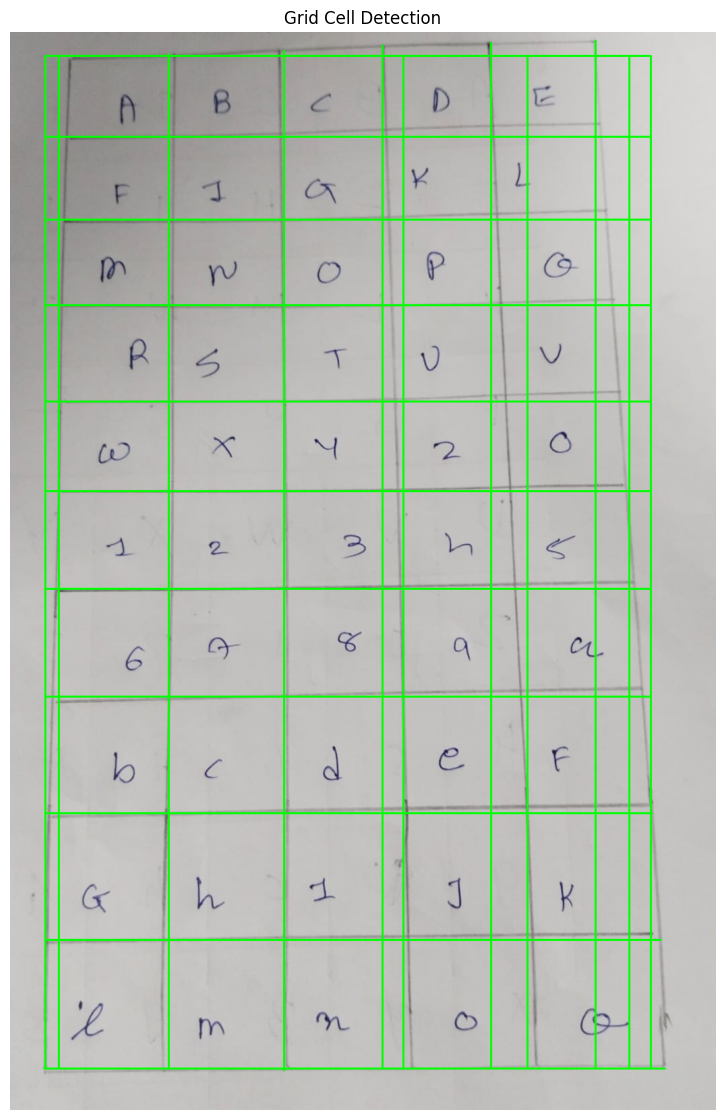

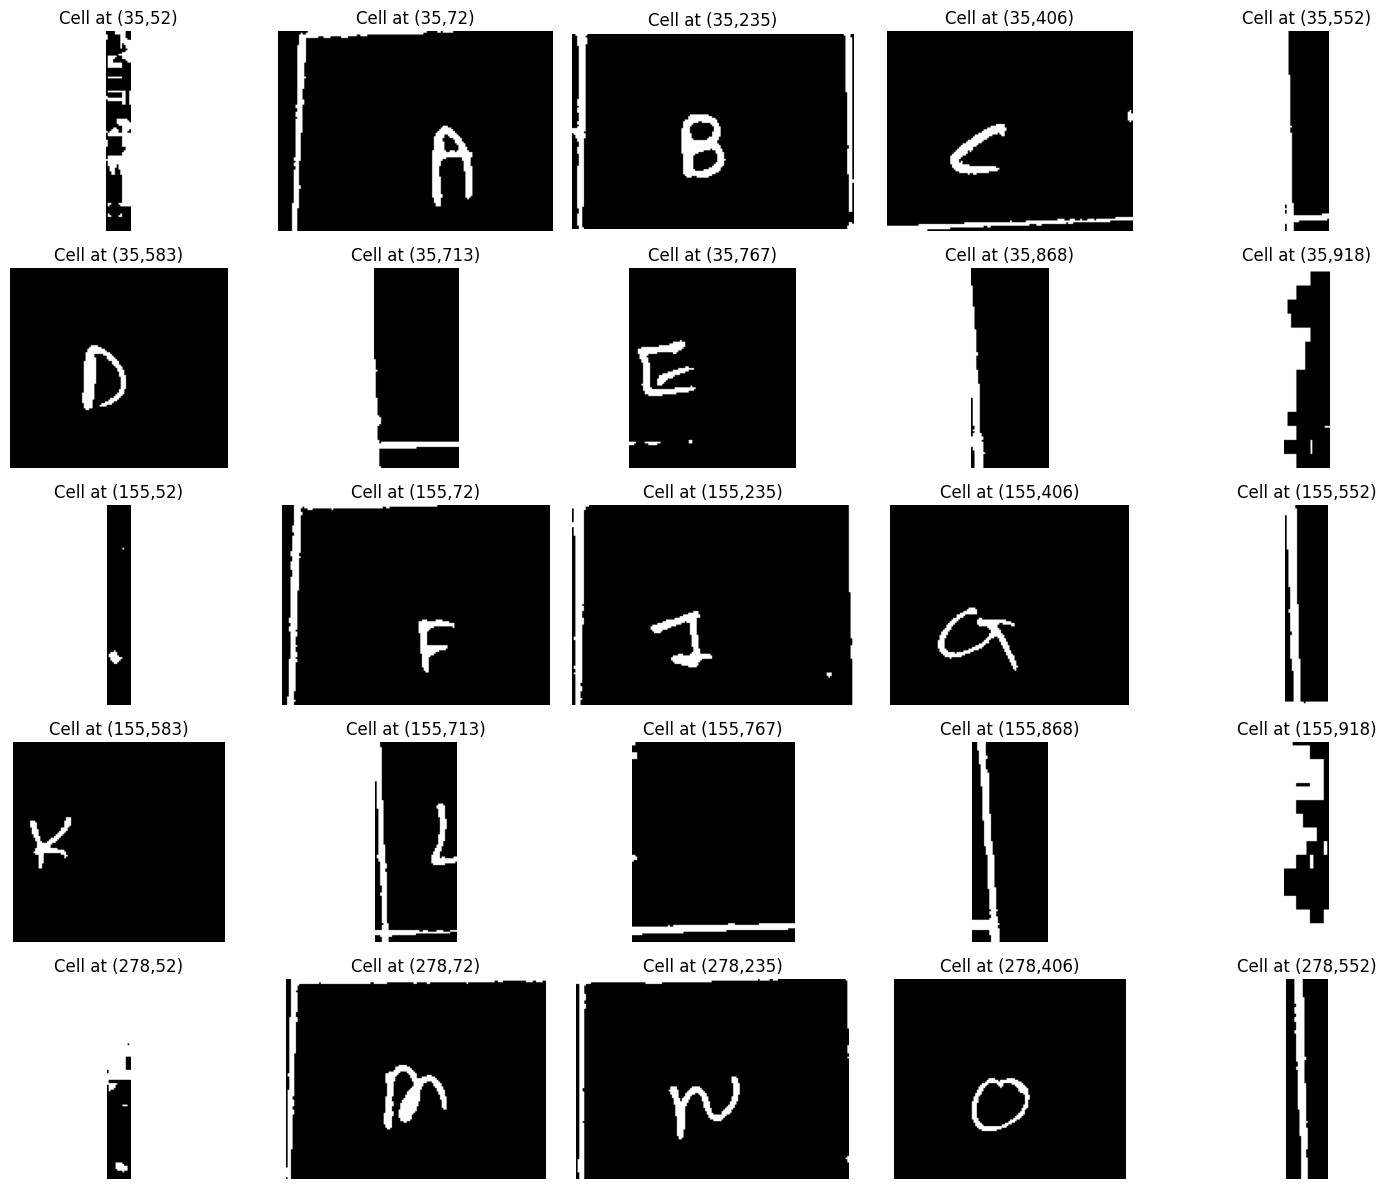

All 100 cells have been extracted and saved to extracted_cells/
Individual characters have been extracted and saved with 'character_' prefix


In [65]:
def main():
    # Replace with your image path
    image_path = "/Users/fenilvadher/Documents/Collage Data/SEM - 6/DL/Task 2 Handwritten Character Recognition using Deep Learning/Rudra_ICT_sem 2.jpeg"
    output_folder = "extracted_cells"
    
    try:
        # Process with line detection approach
        cells, vis_img, cell_boxes = process_grid_image(image_path, output_folder)
        
        # Process each cell to extract just the character
        processed_cells = []
        for i, cell in enumerate(cells):
            char_img = extract_character_from_cell(cell)
            
            # Save the processed character
            cell_filename = f"{output_folder}/character_{i+1}.png"
            cv2.imwrite(cell_filename, char_img)
            
            processed_cells.append(char_img)
        
        # Display the results
        display_results(cells, vis_img, cell_boxes)
        
        print(f"All {len(cells)} cells have been extracted and saved to {output_folder}/")
        print(f"Individual characters have been extracted and saved with 'character_' prefix")
        
    except Exception as e:
        print(f"Error processing image: {e}")

if __name__ == "__main__":
    main()